In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

In [2]:
data = pd.read_csv("data.csv")

# MLE Estimators

1.4864344460664445
0.7795182956841905


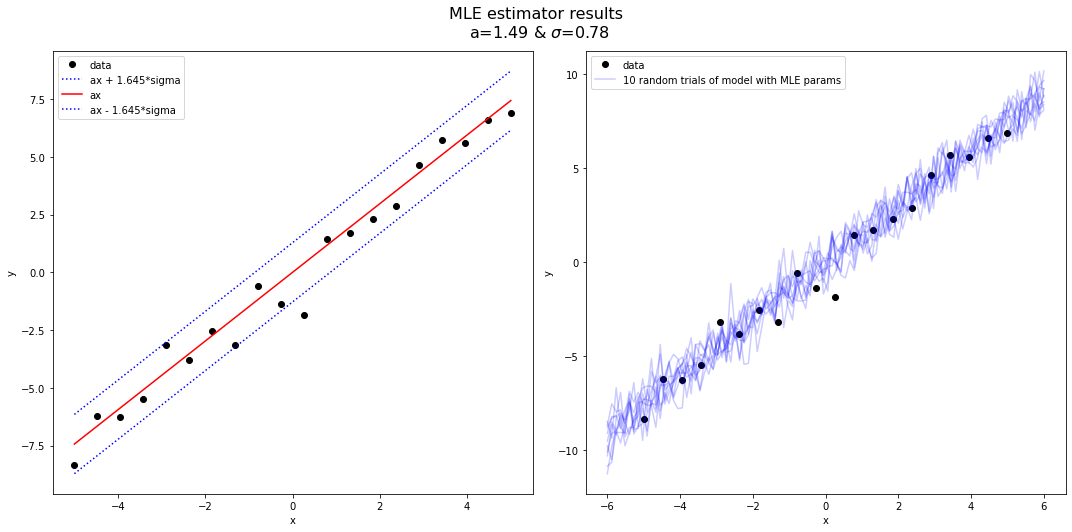

In [3]:
a_num = sum([x*y for x,y in zip(data.x, data.y)])
a_den = sum([x*x for x in data.x])
a = a_num / a_den
print(a)

N = len(data)

sigma = np.sqrt(sum([ (a*x - y)**2 / N for x,y in zip(data.x, data.y) ]))
print(sigma)

def linear_model(xs, a, sigma):
    return [a*x + sigma*np.random.normal(0, 1) for x in xs]

xs = np.linspace(-6, 6, 100)

fig, (ax1, ax2) = plt.subplots(1, 2)

ax1.plot(data.x, data.y, 'ok', label="data")
ax1.plot(data.x, a*data.x + (1.645*sigma), ':b', label="ax + 1.645*sigma")
ax1.plot(data.x, a*data.x, 'r', label="ax")
ax1.plot(data.x, a*data.x - (1.645*sigma), ':b', label="ax - 1.645*sigma")
ax1.set_xlabel("x")
ax1.set_ylabel("y")
ax1.legend()

ax2.plot(data['x'], data['y'], 'ok')
for i in range(10):
    ys = linear_model(xs, a, sigma)
    ax2.plot(xs, ys, 'b', alpha=0.2)
ax2.set_xlabel("x")
ax2.set_ylabel("y")
ax2.legend(["data", "10 random trials of model with MLE params"])

fig.set_size_inches(15, 7.5)
fig.suptitle(f"MLE estimator results\n a={a:0.2f} & $\sigma$={sigma:0.2f}", size=16)

a_mle = a
sigma_mle = sigma

plt.tight_layout()
plt.savefig("mle_plot.jpg")

# Laplacian MAP Estimators

In [4]:
# Use memoization to speed this up
memo_a = {}
memo_sigma = {}

In [5]:
a_s = np.linspace(-5, 5, 1000)
sigmas = np.linspace(0.1, 2, 1000)

X,Y = np.meshgrid(a_s, sigmas)

def compute_exact_log_posterior(a, sigma):
    N = len(data)
    
    if a in memo_a:
        t2 = memo_a[a]
    else:
        t2 = sum([((a * x) - y)**2 for x,y in zip(data.x, data.y)])
        memo_a[a] = t2
    
    if sigma in memo_sigma:
        t1, t3 = memo_sigma[sigma]
    else:
        t1 = (-1 / (2*(sigma ** 2)))
        t3 = -N * np.log(sigma)
        memo_sigma[sigma] = (t1, t3)
    
    t4 = (-N/2) * np.log(2 * np.pi)
    t5 = -np.log(20)
    return (t1*t2) + t3 + t4 + t5
    
Z_logpost = np.zeros(X.shape)

for idx, (x,y) in enumerate(zip(X, Y)):
    for jdx, (xx, yy) in enumerate(zip(x, y)):
        Z_logpost[idx, jdx] = compute_exact_log_posterior(xx, yy)

Locator attempting to generate 4853 ticks ([-388160.0, ..., 0.0]), which exceeds Locator.MAXTICKS (1000).


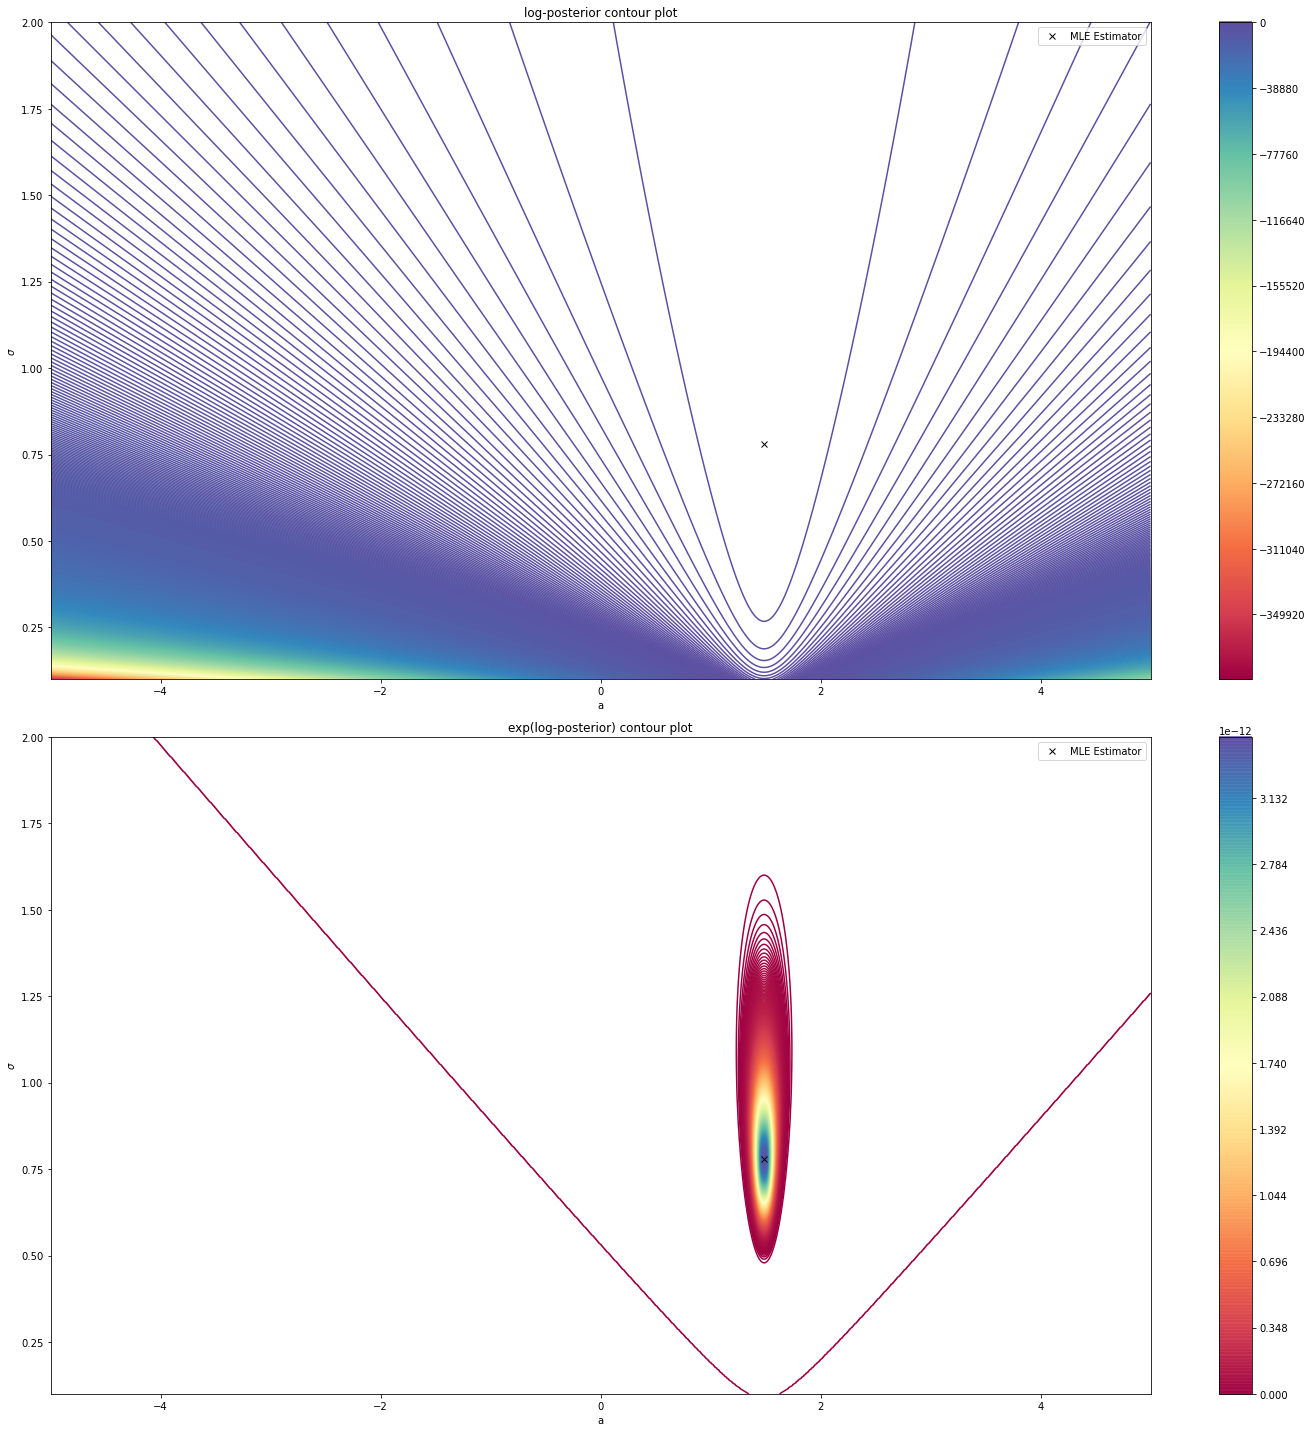

In [6]:
fig, (ax1, ax2) = plt.subplots(2, 1)

contours = ax1.contour(X,Y,Z_logpost, 5000, cmap='Spectral')
plt.colorbar(contours, ax=ax1)

ax1.set_xlabel("a")
ax1.set_ylabel("$\sigma$")
ax1.set_title("log-posterior contour plot")
ax1.plot([a_mle], [sigma_mle], 'kx', label='MLE Estimator')
ax1.legend()

contours = ax2.contour(X, Y, np.exp(Z_logpost), 1000, cmap='Spectral')
plt.colorbar(contours, ax=ax2)
ax2.set_xlabel("a")
ax2.set_ylabel("$\sigma$")
ax2.set_title("exp(log-posterior) contour plot")
ax2.plot([a_mle], [sigma_mle], 'kx', label='MLE Estimator')
ax2.legend()

fig.set_size_inches(20, 20)
plt.tight_layout()
plt.savefig("posterior_density.jpg")

In [7]:
def compute_hessian(a, sigma):
    N = len(data)
    dda = (-1 / (sigma ** 2)) * sum([x ** 2 for x in data.x])
    dds = (N / (sigma ** 2)) - ((3 / sigma ** 4) * sum([(a*x - y)**2 for x,y in zip(data.x, data.y)]))
    dads = (2/(sigma**3)) * sum([(a * (x**2)) - (x*y) for x,y in zip(data.x, data.y)])
    return np.array([[dda, dads], [dads, dds]])

def sample_multivariate_normal(MAP, Sigma):
    return np.random.multivariate_normal(MAP, Sigma)

def laplace_approximation(a, s, MAP, Sigma):
    data = np.array([[a], [s]])
    MAP = MAP.reshape(2, 1)
    return (1/(2*np.pi)) * (np.linalg.det(Sigma) ** (-1/2)) * np.exp((-1/2) * ((data - MAP).T @ np.linalg.inv(Sigma) @ (data - MAP)).flatten())

MAP = np.array([a_mle, sigma_mle])
H = compute_hessian(a_mle, sigma_mle)
Sigma = np.linalg.inv(-H)
print("Sigma:", Sigma, "is symmetric")
print()
evals, evecs = np.linalg.eig(Sigma)
print("eigenvalues(S) = ", evals, "(all positive)")

Sigma: [[3.29866477e-03 3.19470684e-18]
 [3.19470684e-18 1.51912193e-02]] is symmetric

eigenvalues(S) =  [0.00329866 0.01519122] (all positive)


In [8]:
Z_laplace = np.zeros(X.shape)
for idx, (x,y) in enumerate(zip(X, Y)):
    for jdx, (xx, yy) in enumerate(zip(x, y)):
        Z_laplace[idx, jdx] = laplace_approximation(xx, yy, MAP, Sigma)

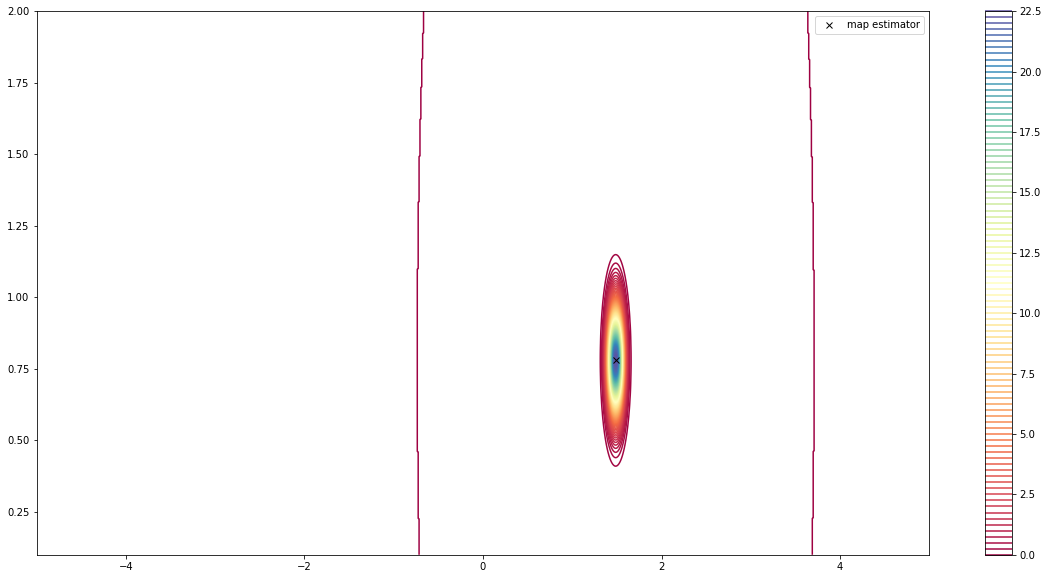

In [9]:
fig, ax1 = plt.subplots(1, 1)

contour = ax1.contour(X, Y, Z_laplace, 100, cmap='Spectral')
plt.colorbar(contour, ax=ax1)
ax1.plot([a_mle], [sigma_mle], 'kx', label='map estimator')
ax1.legend()

fig.set_size_inches(20, 10)
plt.savefig("laplace_approx_of_posterior.jpg")

# Metropolis Hastings Sampling of Log-Posterior

In [10]:
import scipy.stats as stat

def target_pdf(a, sigma):
    # Penalize negative sigma
    if sigma <= 0:
        return np.exp(-1e20)
    N = len(data)
    
    t1 = (-1 / (2*(sigma ** 2)))
    t2 = sum([((a * x) - y)**2 for x,y in zip(data.x, data.y)])
    t3 = -N * np.log(sigma)
    t4 = (-N/2) * np.log(2 * np.pi)
    t5 = -np.log(20)
    
    return np.exp((t1*t2) + t3 + t4 + t5)

def easy_pdf(x, mean, sigma):
    return stat.norm.pdf(x, loc=mean, scale=sigma)

def sample_easy(prev, sigma):
    return stat.norm.rvs(loc=prev, scale=sigma)

def propose_next_state(prev_vec, sigma):
    return np.array([sample_easy(x, sigma) for x in prev_vec])


def run_metropolis_hastings(sigma):
    N_iter = 1000
    xs_array = np.zeros((N_iter, 2))
    num_rejected = 0

    x_n = MAP
    for idx in range(N_iter):
        xs_array[idx, :] = x_n
        # Compute proposed transition
        x_prime = propose_next_state(x_n, sigma)

        # Compute alpha
        numerator = target_pdf(x_prime[0], x_prime[1]) * easy_pdf(x_n[0], x_prime[0], sigma) * easy_pdf(x_n[1], x_prime[1], sigma)
        denominator = target_pdf(x_n[0], x_n[1]) * easy_pdf(x_prime[0], x_n[0], sigma) * easy_pdf(x_prime[1], x_n[1], sigma)
        
        alpha = min(1, numerator / denominator)
        
        # Draw random number to determine if alpha accepted.
        rand = np.random.uniform(0, 1)
        if rand < alpha:
            # Transition Accepted
            x_n = x_prime 
        else:
            # Transition Rejected
            num_rejected += 1
    return xs_array, num_rejected


In [11]:
avg_rr = []
ss = np.logspace(-4, 1, num=100)
for sigma in ss:
    total_rej = 0
    for i in range(5):
        _, num_rejected = run_metropolis_hastings(sigma)
        total_rej += num_rejected
    avg_rr.append(total_rej / 5)

best sigma found: 0.09545484566618337 for rejection rate of: 500.0 (rejected out of 1000)


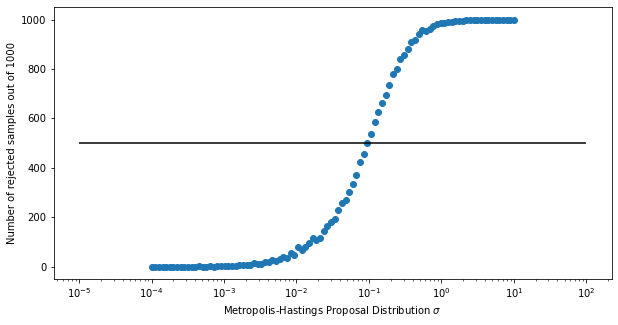

In [12]:
f, ax = plt.subplots(1, 1)
ax.plot(ss, avg_rr, 'o')
ax.hlines(500, 1e-5, 1e2, 'k')
ax.set_xscale('log')
ax.set_xlabel('Metropolis-Hastings Proposal Distribution $\sigma$')
ax.set_ylabel("Number of rejected samples out of 1000")

best_sigma = None
best_rr = None
found = False
for idx, (i,j) in enumerate(zip(ss, avg_rr)):
    if j > 500 and not found:
        best_sigma = ss[idx-1]
        best_rr = avg_rr[idx-1]
        found = True
print("best sigma found:", best_sigma, "for rejection rate of:", best_rr, "(rejected out of 1000)")
f.set_size_inches(10, 5)
plt.savefig("metrop_hastings_sigma_curve.jpg")

Locator attempting to generate 4853 ticks ([-388160.0, ..., 0.0]), which exceeds Locator.MAXTICKS (1000).


Number rejected: 541


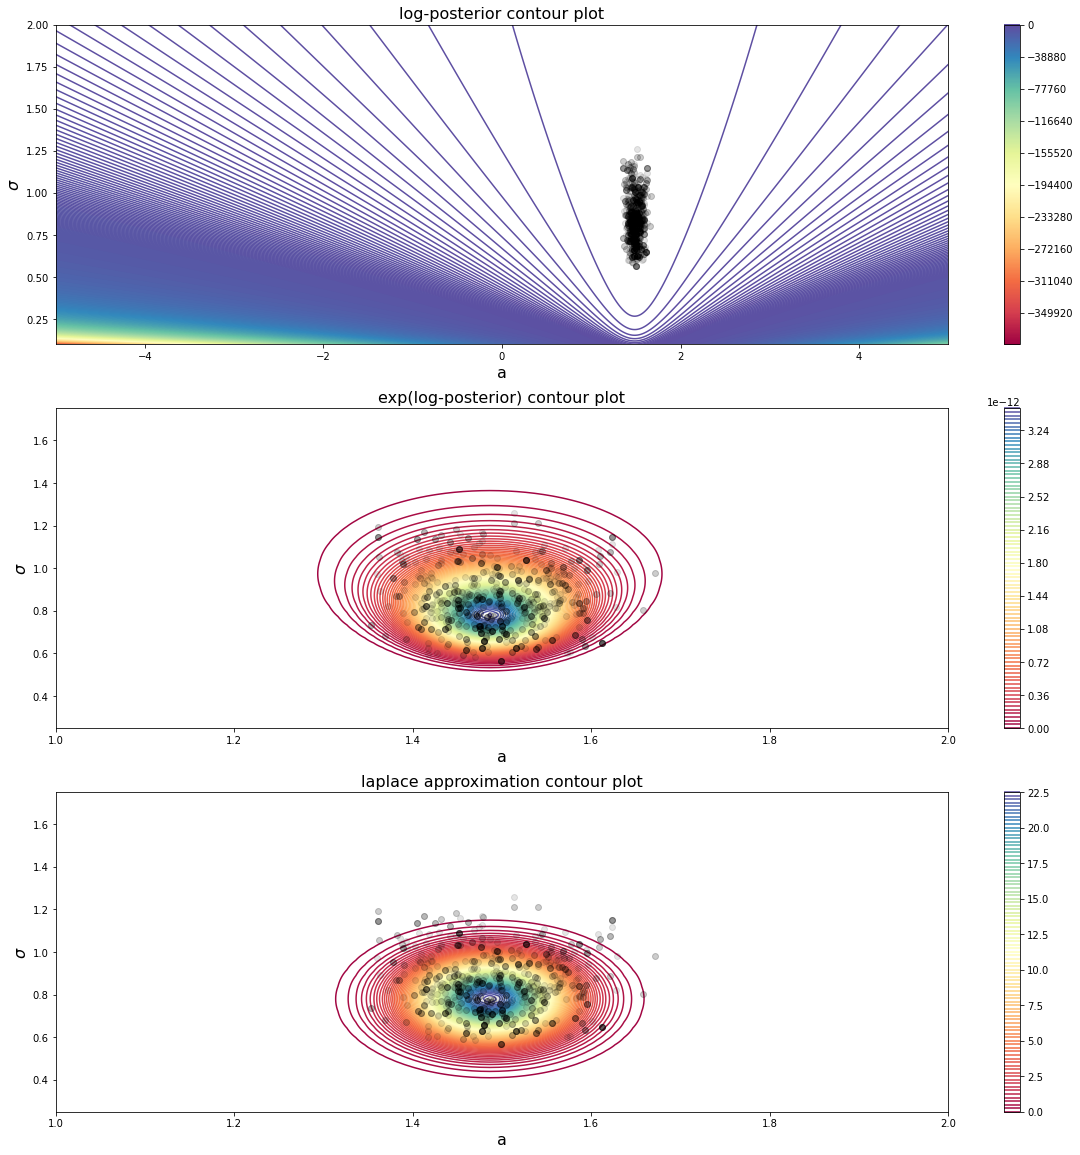

In [13]:
samples, num_rejected = run_metropolis_hastings(best_sigma)

fig, (ax1, ax2, ax3) = plt.subplots(3, 1)

contours = ax1.contour(X, Y, Z_logpost, 5000, cmap='Spectral')
plt.colorbar(contours, ax=ax1)

ax1.set_xlabel("a", size=16)
ax1.set_ylabel("$\sigma$", size=16)
ax1.set_title("log-posterior contour plot", size=16)
ax1.scatter(samples[:, 0], samples[:, 1], zorder=10, alpha=0.1, c='k')

contours = ax2.contour(X, Y, np.exp(Z_logpost), 100, cmap='Spectral')
plt.colorbar(contours, ax=ax2)
ax2.set_xlabel("a", size=16)
ax2.set_ylabel("$\sigma$", size=16)
ax2.set_title("exp(log-posterior) contour plot", size=16)
ax2.scatter(samples[:, 0], samples[:, 1], zorder=10, alpha=0.1, c='k')
ax2.set_xlim(1, 2)
ax2.set_ylim(0.25, 1.75)

contour = ax3.contour(X, Y, Z_laplace, 100, cmap='Spectral')
plt.colorbar(contour, ax=ax3)
ax3.scatter(samples[:, 0], samples[:, 1], zorder=10, alpha=0.1, c='k')
ax3.set_title("laplace approximation contour plot", size=16)
ax3.set_xlabel("a", size=16)
ax3.set_ylabel("$\sigma$", size=16)
ax3.set_xlim(1, 2)
ax3.set_ylim(0.25, 1.75)

print("Number rejected:", num_rejected)

fig.set_size_inches(20, 20)
plt.savefig("MH_sampling_over_contour_plots.jpg")

In [14]:
integral = 0
avg = np.zeros((len(samples[:, 0]), 20))
for idx, (a, sigma) in enumerate(samples):
    pred_ys = linear_model(data.x, a, sigma)
    avg[idx, :] = pred_ys

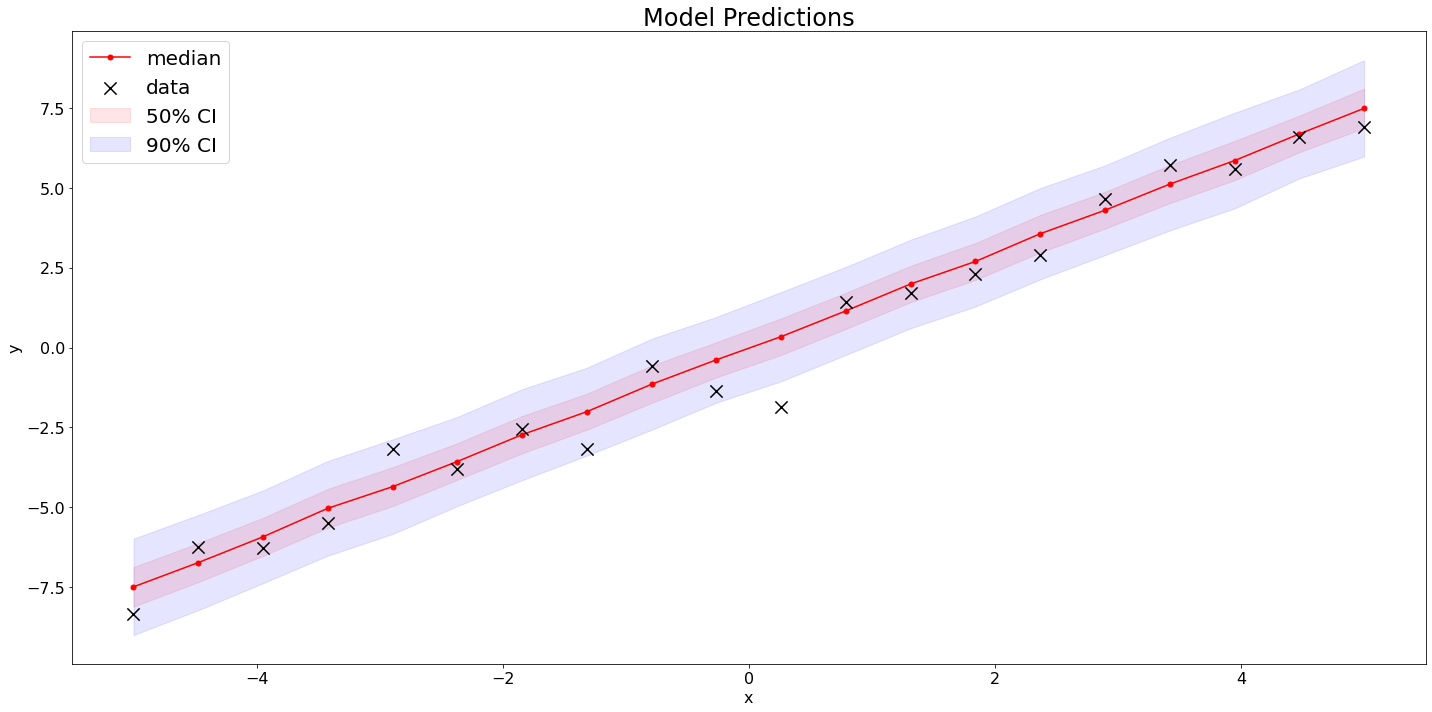

In [15]:
meds = []
stds = []
for i in range(20):
    meds.append(np.median(avg[:, i]))
    stds.append(np.std(avg[:, i]))
    
# for i in range(len(samples)):
#     plt.plot(data.x, avg[i, :], 'k', alpha=0.01)


plt.plot(data.x, meds, '-or', markersize=5, label="median")
plt.scatter(data.x, data.y, marker='x', c="black", zorder=10, s=150, label="data")
# plt.scatter(data.x, )
# plt.scatter(data.x, )
plt.fill_between(data.x, [x - 0.67449*y for x,y in zip(meds, stds)], [x + 0.67449*y for x,y in zip(meds, stds)], color='r', alpha=.1, label="50% CI")
plt.fill_between(data.x, [x - 1.645*y for x,y in zip(meds, stds)], [x + 1.645*y for x,y in zip(meds, stds)], color='b', alpha=.1, label="90% CI")
plt.legend(fontsize=20)
plt.xlabel("x", size=16)
plt.xticks(size=16)
plt.yticks(size=16)
plt.ylabel("y", size=16)
plt.title("Model Predictions", size=24)

plt.gcf().set_size_inches(20,10)
plt.tight_layout()
plt.savefig("medians_and_conf_intervals.jpg")